In [1]:
import numpy as np
import cam_fkns as camfk
import pickle
from epics import caget, caput
import time
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_act(mots, motpos, timeout = 60):
    for i, mot in enumerate(mots):
        caput(mot + ':MOT.VAL', motpos[i])
    time.sleep(0.1)
    mov = True
    while mov:
        status = 0
        for mot in mots:
            status = status + (caget(mot + ':MOT.DMOV') - 1)
        mov = bool(status)
        time.sleep(0.1)
        timeout -= 0.1
        if timeout <= 0:
            print('TIMEOUT:   ({} s) while moving motors'.format(timeout))
            return False
    return True
        
def get_motpos(mots):
    motpos = []
    for mot in mots:
        motpos.append(caget(mot + ':MOT.RBV'))
    return motpos
        
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


class progress_bar():
    def __init__(self, bar_length=80):
        self.length = bar_length
        self.block = int(0)
        self.progress = 0.0
        #text = "Progress: [{0}] {1:.1f}%".format( "#" * self.block + "-" * (self.length - self.block), self.progress * 100)
        self.dh = display('Init Progress Bar',display_id=True)

    
    def update(self, progress):
        if isinstance(progress, int):
            self.progress = float(progress)
        if not isinstance(progress, float):
            self.progress = 0
        if progress < 0:
            self.progress = 0
        if progress >= 1:
            self.progress = 1
        else:
            self.progress = progress

        self.block = int(round(self.length * self.progress))
        text = "Progress: [{0}] {1:.1f}%".format( "#" * self.block + "-" * (self.length - self.block), self.progress * 100)
        try:
            self.dh.update(text)
        except:
            if self.progress == 1:
                print(text)
            else:
                print(text, end='\r', flush=True)
            
    


In [3]:
#with open('Rot_Angle.npy', 'rb') as f:
#    Rot = np.load(f)

alpha_x = np.arctan(0.37)
alpha_y = np.arctan(-0.37)

R1 = np.array([[np.cos(alpha_x), -np.sin(alpha_x)], [np.sin(alpha_x), np.cos(alpha_x)]])
R2 = np.array([[np.cos(alpha_y), -np.sin(alpha_y)], [np.sin(alpha_y), np.cos(alpha_y)]])

In [4]:
# Test Data
# range and resolution for scan
#scanrange = np.array([[-10, 10, 10], [-2, 2, 3], [-10, 10, 10], [-2, 2, 3]])

M1x = np.linspace(-300, 300, num=30)
M1y = np.linspace(-300, 300, num=30)
M2x = np.linspace(-10, 10, num=10)
M2y = np.linspace(-10, 10, num=10)

scanrange = np.array([M1x, M1y, M2x, M2y])

# Compute scan arrays
# rangearray = []
# for i, scan in enumerate(scanrange):
# rangearray.append(np.linspace(scan[0], scan[1], scan[2], endpoint=True))
scanarray = cartesian(tuple(scanrange))

scanarray1 = (np.array([scanarray[:,0], scanarray[:,2]]).T).dot(np.linalg.inv(R1))
scanarray2 = (np.array([scanarray[:,1], scanarray[:,3]]).T).dot(np.linalg.inv(R2))

scanarray_new = np.array([scanarray1[:,0], scanarray2[:,0], scanarray1[:,1], scanarray2[:,1]]).T

In [ ]:
plt.scatter(scanarray_new[:,0], scanarray_new[:,2])
plt.show()
plt.scatter(scanarray_new[:,1], scanarray_new[:,3])

In [5]:
# Alcor
# cams = ['SLG-LCAM-C072', 'SLG-LCAM-C063', 'SLG-LCAM-C081']
# mots = ['SLG-LMOT-M077', 'SLG-LMOT-M078', 'SLG-LMOT-M047', 'SLG-LMOT-M048']

# Mizar
# cams = ['SLG-LCAM-C031', 'SLG-LCAM-C032', 'SLG-LCAM-C033']
# mots = ['SLG-LMOT-M031', 'SLG-LMOT-M032', 'SLG-LMOT-M033', 'SLG-LMOT-M034']

# TWLHA
cams = ['TWLHA-LCAM-C103']

mots = ['TWLHA-LMOT-MW31', 'TWLHA-LMOT-MW32', 'TWLHA-LMOT-MW33', 'TWLHA-LMOT-MW34']

motinit = get_motpos(mots)

# compute scan arrays
rangearray = []
for scan in scanarray_new:
    rangearray.append([])
    for i, pos in enumerate(scan):
        rangearray[-1].append(pos + motinit[i])
rangearray = np.array(rangearray)

t = 0.5
nr = rangearray.shape[0]
print('{} datasets will be aquired in about {} hours'.format(nr, nr * t / 3600))

90000 datasets will be aquired in about 12.5 hours


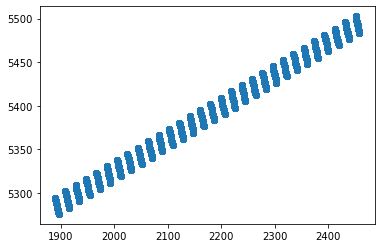

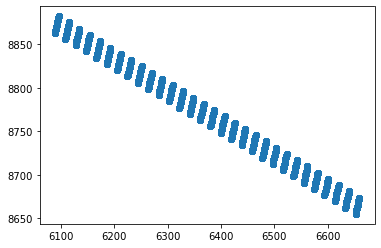

In [6]:
plt.scatter(rangearray[:,0], rangearray[:,2])
plt.show()
plt.scatter(rangearray[:,1], rangearray[:,3])

In [7]:
data = []
prog = progress_bar()
n = rangearray.shape[0]
for i, pos in enumerate(rangearray):
    set_act(mots, pos)
    time.sleep(t)
    data.append({})
    #for cam in cams:
    #    data[-1][cam] = camfk.get_multiple_lcam_images(cam, 1)
    #    integral = caget('TWLHA-LCAM-C103:INTEGRAL_AVE')
    #    data[-1]['integral'] = integral
    #if not bool(caget('TWLHA-LCAM-C103:CHI_GOOD')):
    integral = caget('TWLHA-LCAM-C103:INTEGRAL_AVE')
    data[-1] = {'integral': integral}
    data[-1]['motpos'] = get_motpos(mots)
    prog.update(i/(n-1))

set_act(mots, motinit)
    

'Progress: [################################################################################] 100.0%'

CA.Client.Exception...............................................
    Context: "Channel: "TWLHA-LCAM-C103:INTEGRAL_AVE", Connecting to: 172.21.11.146:43459, Ignored: pc14973:43459"
    Source File: ../cac.cpp line 1320
    Current Time: Wed Feb 16 2022 14:08:44.919834102
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "TWLHA-LCAM-C103:INTEGRAL_AVE", Connecting to: 172.21.11.146:43459, Ignored: pc14973:43459"
    Source File: ../cac.cpp line 1320
    Current Time: Wed Feb 16 2022 14:08:44.924065095
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "TWLHA-LCAM-C103:INTEGRAL_AVE", Connecting to: 172.21.11.146:43459, Ignored: pc14973:43459"
    Source File: ../cac.cpp line 1320
    Current Time: Wed Feb 16 2022 14:08:44.928183085
...............................................

True

In [ ]:
rangearray[0]

In [ ]:
camfk.get_multiple_lcam_images(cams[0], 1)

In [ ]:
set_act(mots, motinit)

In [8]:
with open('2022-02-16WLHA.pickle', 'wb') as f:
    pickle.dump(data, f, protocol=2)  # pickle.HIGHEST_PROTOCOL)

In [ ]:
# read
with open('WLHAFirst.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
class camopts():
    def __init__(self):
        self.opts_loc = {'cmap':'jet', 'crosssec':{'enabled':True, 'type':'projection'}, 'save':False, 'show':True}
camopts = camopts()
camfk.camplot(camopts, data[30]['SLG-LCAM-C081'])

In [ ]:
import dill  
# I edited C:\Anaconda\envs\gfa\Lib\site-packages\dill\_dill.py
import IPython
IPython.core.shadowns = 1



filepath = 'MizarFullShifted.pkl'
#dill.dump_session(filepath) # Save the session
dill.load_session(filepath) # Load the session
